In [1]:
import os, sys
import torch
import numpy as np

from models import build_DABDETR, build_dab_deformable_detr
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# Init and Load Pre-trained Models

In [2]:
model_config_path = "model_zoo/DAB_DETR/R50/config.json" # change the path of the model config file
model_checkpoint_path = "model_zoo/DAB_DETR/R50/checkpoint.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.


In [3]:
args = SLConfig.fromfile(model_config_path) 
model, criterion, postprocessors = build_DABDETR(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

# Load Datasets

In [4]:
dataset_val = build_dataset(image_set='val', args=args)
cocojs = dataset_val.coco.dataset
id2name = {item['id']: item['name'] for item in cocojs['categories']}

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


# Get an Example and Visualize it

In [5]:
image, targets = dataset_val[0]

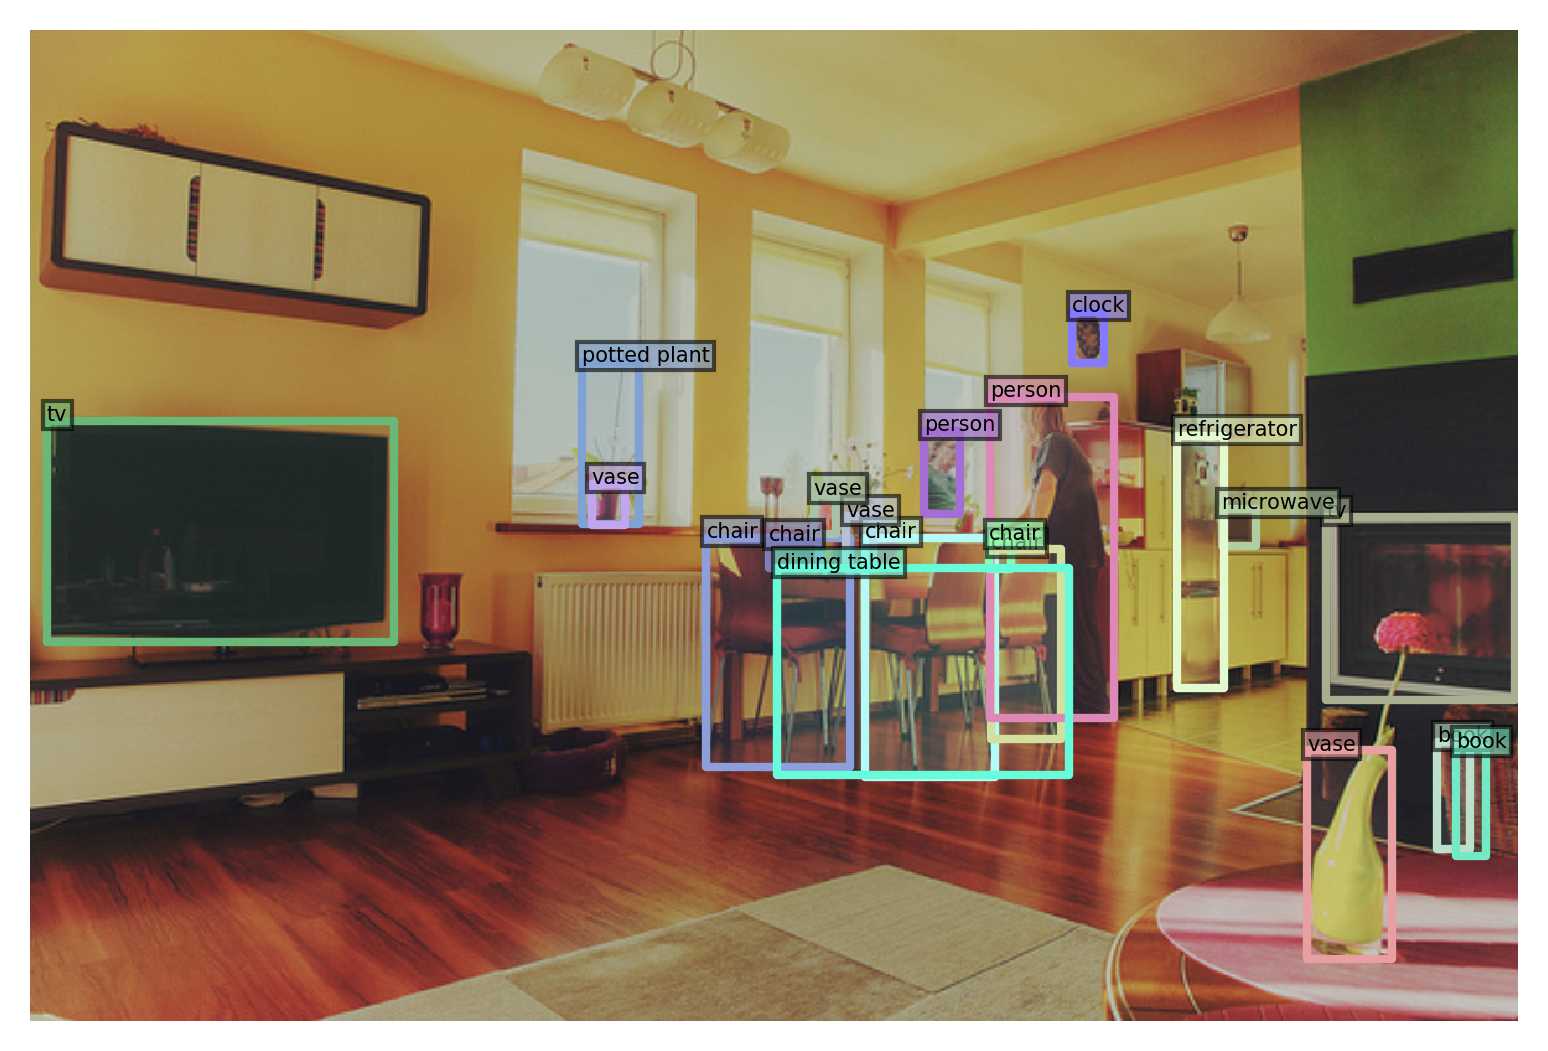

In [6]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

# Visualize Model Predictions

In [7]:
output = model(image[None])
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]))[0]

/comp_robot/liushilong/anaconda3/envs/q2x/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/comp_robot/liushilong/anaconda3/envs/q2x/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_162344826523

In [8]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

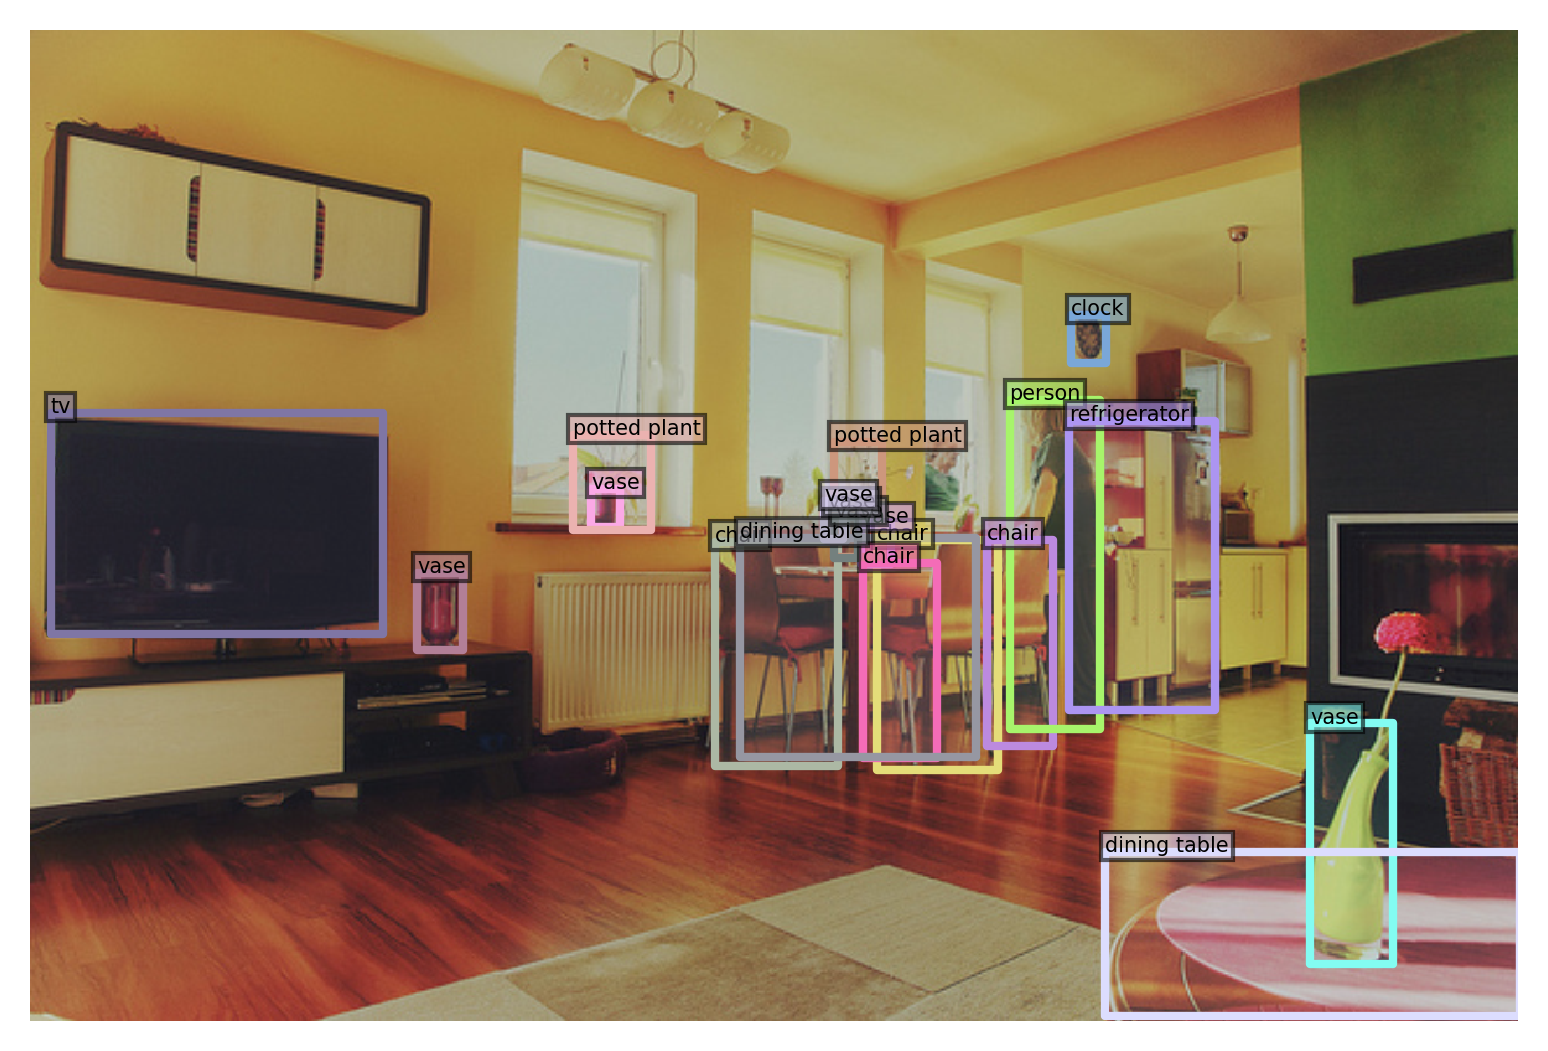

In [9]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)